## Ver.3  
- Ver.2보다 epoch을 줄였음
- Intensity를 랜덤하게 조정(RandScaleIntensityd, RandShiftIntensityd)
- 이미지를 랜덤하게 자르도록 설정 (RandSpatialCropd)
- Ver.2보다 best mean dice가 올랐으며, test set에서도 향상된 결과를 얻음

# Image segmentation (3D UNET)


In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 1.0 MB 5.1 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path0 = '/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train'
dpiv = 80

In [ ]:
from monai.transforms import *
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first

from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference
from monai.networks.layers import Norm

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

cuda:0


In [ ]:
path_list = glob.glob(os.path.join(path0,'Brats18*'))
len(path_list)

100

### data split (train/valid)

In [ ]:
train_ind = np.arange(0,80)
data_dicts = [
    {
        "image": os.path.join(path_list[idx],
                                    "t1ce.nii.gz"),
        "label": os.path.join(path_list[idx],
                                    "seg.nii.gz"),
    }
    for idx in train_ind
]
train_files =  data_dicts

In [ ]:
valid_ind = np.arange(80,100)
data_dicts = [
    {
        "image": os.path.join(path_list[idx],
                                    "t1ce.nii.gz"),
        "label": os.path.join(path_list[idx],
                                    "seg.nii.gz"),
    }
    for idx in valid_ind
]
valid_files =  data_dicts

In [ ]:
train_transforms = Compose(
    [
      LoadImaged(keys=("image","label")),
      AddChanneld(keys=("image","label")),
      CenterSpatialCropd(keys=["image", "label"], roi_size=[192, 192, 96]),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      RandSpatialCropd(keys=["image", "label"], roi_size=[160, 160, 64],random_size=False),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
      RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
      RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
      ToTensord(keys=["image", "label"]),
    ]
)

valid_transforms = Compose(
    [
      LoadImaged(keys=("image","label")),
      AddChanneld(keys=("image","label")),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      ToTensord(keys=["image", "label"]),
    ]
)

In [ ]:
train_ds = Dataset(data = train_files, transform = train_transforms)
train_loader = DataLoader(train_ds,batch_size = 2)

In [ ]:
valid_ds = Dataset(data = valid_files, transform = valid_transforms)
valid_loader = DataLoader(valid_ds,batch_size = 1)

- check transformation

(2, 1, 160, 160, 64)
(2, 1, 160, 160, 64)


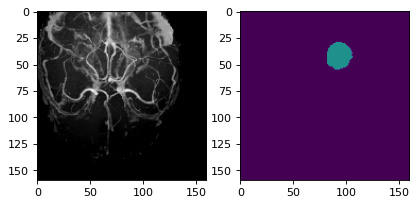

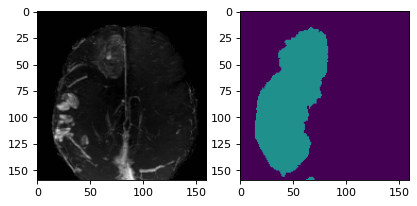

In [ ]:
cnt = 0
for data in train_loader:
  print(data["image"].shape)
  print(data["label"].shape)

  for n in range(0,len(data["image"])):
    plt.figure(dpi=dpiv)
    plt.subplot(121)
    plt.imshow(np.transpose(np.max(data["image"][n,0,:,:,:].numpy(),axis=2),(1,0)),cmap='gray')

    label = (data["label"]==1).type(torch.FloatTensor) + (data["label"]==2).type(torch.FloatTensor) + (data["label"]==4).type(torch.FloatTensor) 
    plt.subplot(122)
    plt.imshow(np.transpose(np.max(label[n,0,:,:,:].numpy(),axis=2),(1,0)),vmin=0,vmax=2)
    plt.show()

  break


# Model

In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)


# Train

----------
epoch 1/150
epoch 1 average loss: 0.6407
----------
epoch 2/150
epoch 2 average loss: 0.6118
----------
epoch 3/150
epoch 3 average loss: 0.5946
----------
epoch 4/150
epoch 4 average loss: 0.5798
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA06_332_1/t1ce.nii.gz']


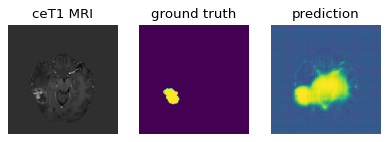

saved new best metric model
current epoch: 4 current mean dice: 0.4253
best mean dice: 0.4253 at epoch: 4
----------
epoch 5/150
epoch 5 average loss: 0.5666
----------
epoch 6/150
epoch 6 average loss: 0.5561
----------
epoch 7/150
epoch 7 average loss: 0.5433
----------
epoch 8/150
epoch 8 average loss: 0.5330
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA08_105_1/t1ce.nii.gz']


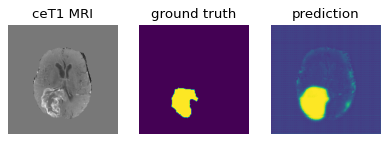

saved new best metric model
current epoch: 8 current mean dice: 0.4613
best mean dice: 0.4613 at epoch: 8
----------
epoch 9/150
epoch 9 average loss: 0.5249
----------
epoch 10/150
epoch 10 average loss: 0.5113
----------
epoch 11/150
epoch 11 average loss: 0.4996
----------
epoch 12/150
epoch 12 average loss: 0.4906
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA04_111_1/t1ce.nii.gz']


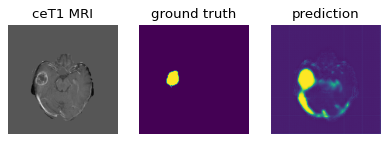

saved new best metric model
current epoch: 12 current mean dice: 0.4942
best mean dice: 0.4942 at epoch: 12
----------
epoch 13/150
epoch 13 average loss: 0.4776
----------
epoch 14/150
epoch 14 average loss: 0.4696
----------
epoch 15/150
epoch 15 average loss: 0.4595
----------
epoch 16/150
epoch 16 average loss: 0.4490
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA08_234_1/t1ce.nii.gz']


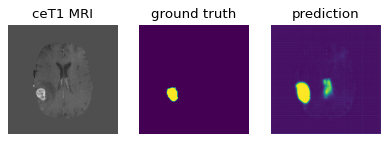

saved new best metric model
current epoch: 16 current mean dice: 0.5207
best mean dice: 0.5207 at epoch: 16
----------
epoch 17/150
epoch 17 average loss: 0.4498
----------
epoch 18/150
epoch 18 average loss: 0.4368
----------
epoch 19/150
epoch 19 average loss: 0.4226
----------
epoch 20/150
epoch 20 average loss: 0.4132
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA03_296_1/t1ce.nii.gz']


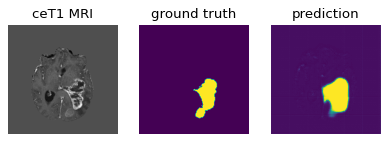

saved new best metric model
current epoch: 20 current mean dice: 0.5448
best mean dice: 0.5448 at epoch: 20
----------
epoch 21/150
epoch 21 average loss: 0.3978
----------
epoch 22/150
epoch 22 average loss: 0.3936
----------
epoch 23/150
epoch 23 average loss: 0.3822
----------
epoch 24/150
epoch 24 average loss: 0.3638
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA05_444_1/t1ce.nii.gz']


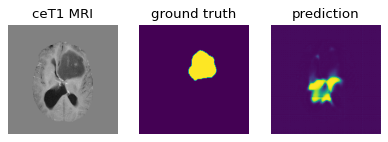

saved new best metric model
current epoch: 24 current mean dice: 0.5764
best mean dice: 0.5764 at epoch: 24
----------
epoch 25/150
epoch 25 average loss: 0.3628
----------
epoch 26/150
epoch 26 average loss: 0.3498
----------
epoch 27/150
epoch 27 average loss: 0.3363
----------
epoch 28/150
epoch 28 average loss: 0.3307
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA03_257_1/t1ce.nii.gz']


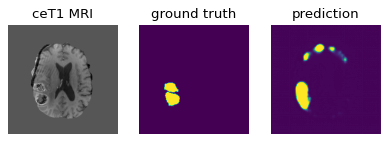

saved new best metric model
current epoch: 28 current mean dice: 0.6239
best mean dice: 0.6239 at epoch: 28
----------
epoch 29/150
epoch 29 average loss: 0.3144
----------
epoch 30/150
epoch 30 average loss: 0.3023
----------
epoch 31/150
epoch 31 average loss: 0.2949
----------
epoch 32/150
epoch 32 average loss: 0.2834
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA04_192_1/t1ce.nii.gz']


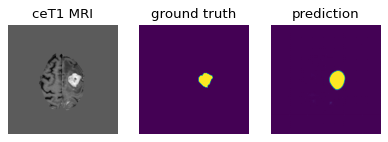

saved new best metric model
current epoch: 32 current mean dice: 0.6651
best mean dice: 0.6651 at epoch: 32
----------
epoch 33/150
epoch 33 average loss: 0.2638
----------
epoch 34/150
epoch 34 average loss: 0.2599
----------
epoch 35/150
epoch 35 average loss: 0.2346
----------
epoch 36/150
epoch 36 average loss: 0.2281
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA08_234_1/t1ce.nii.gz']


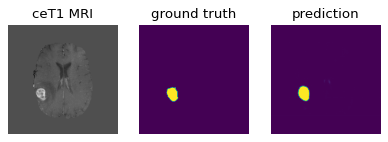

saved new best metric model
current epoch: 36 current mean dice: 0.7195
best mean dice: 0.7195 at epoch: 36
----------
epoch 37/150
epoch 37 average loss: 0.2302
----------
epoch 38/150
epoch 38 average loss: 0.2140
----------
epoch 39/150
epoch 39 average loss: 0.1978
----------
epoch 40/150
epoch 40 average loss: 0.2002
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA08_234_1/t1ce.nii.gz']


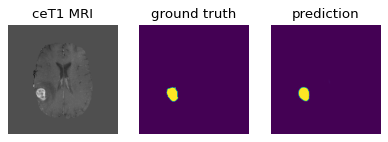

saved new best metric model
current epoch: 40 current mean dice: 0.7354
best mean dice: 0.7354 at epoch: 40
----------
epoch 41/150
epoch 41 average loss: 0.1846
----------
epoch 42/150
epoch 42 average loss: 0.1792
----------
epoch 43/150
epoch 43 average loss: 0.1824
----------
epoch 44/150
epoch 44 average loss: 0.1592
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA06_332_1/t1ce.nii.gz']


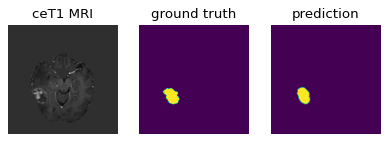

saved new best metric model
current epoch: 44 current mean dice: 0.7827
best mean dice: 0.7827 at epoch: 44
----------
epoch 45/150
epoch 45 average loss: 0.1620
----------
epoch 46/150
epoch 46 average loss: 0.1542
----------
epoch 47/150
epoch 47 average loss: 0.1622
----------
epoch 48/150
epoch 48 average loss: 0.1570
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA08_162_1/t1ce.nii.gz']


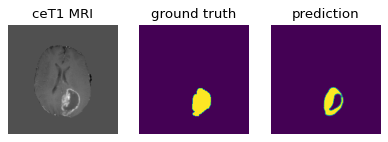

saved new best metric model
current epoch: 48 current mean dice: 0.7972
best mean dice: 0.7972 at epoch: 48
----------
epoch 49/150
epoch 49 average loss: 0.1406
----------
epoch 50/150
epoch 50 average loss: 0.1312
----------
epoch 51/150
epoch 51 average loss: 0.1437
----------
epoch 52/150
epoch 52 average loss: 0.1548
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA04_437_1/t1ce.nii.gz']


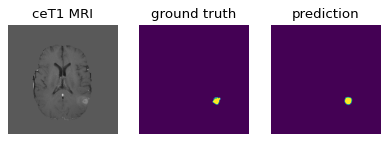

saved new best metric model
current epoch: 52 current mean dice: 0.8192
best mean dice: 0.8192 at epoch: 52
----------
epoch 53/150
epoch 53 average loss: 0.1312
----------
epoch 54/150
epoch 54 average loss: 0.1327
----------
epoch 55/150
epoch 55 average loss: 0.1209
----------
epoch 56/150
epoch 56 average loss: 0.1167
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA04_437_1/t1ce.nii.gz']


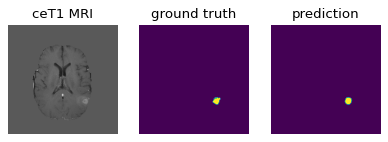

saved new best metric model
current epoch: 56 current mean dice: 0.8192
best mean dice: 0.8192 at epoch: 56
----------
epoch 57/150
epoch 57 average loss: 0.1109
----------
epoch 58/150
epoch 58 average loss: 0.1173
----------
epoch 59/150
epoch 59 average loss: 0.1187
----------
epoch 60/150
epoch 60 average loss: 0.1306
saved new best metric model
current epoch: 60 current mean dice: 0.8321
best mean dice: 0.8321 at epoch: 60
----------
epoch 61/150
epoch 61 average loss: 0.1047
----------
epoch 62/150
epoch 62 average loss: 0.1280
----------
epoch 63/150
epoch 63 average loss: 0.1199
----------
epoch 64/150
epoch 64 average loss: 0.1054
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA04_111_1/t1ce.nii.gz']


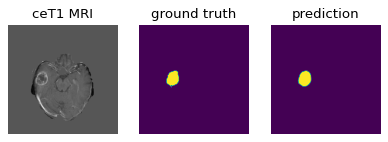

saved new best metric model
current epoch: 64 current mean dice: 0.8388
best mean dice: 0.8388 at epoch: 64
----------
epoch 65/150
epoch 65 average loss: 0.1020
----------
epoch 66/150
epoch 66 average loss: 0.1113
----------
epoch 67/150
epoch 67 average loss: 0.1325
----------
epoch 68/150
epoch 68 average loss: 0.1076
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA04_111_1/t1ce.nii.gz']


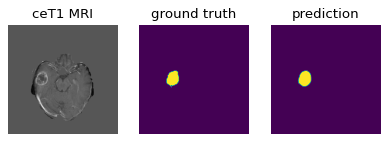

current epoch: 68 current mean dice: 0.8242
best mean dice: 0.8388 at epoch: 64
----------
epoch 69/150
epoch 69 average loss: 0.0931
----------
epoch 70/150
epoch 70 average loss: 0.0996
----------
epoch 71/150
epoch 71 average loss: 0.1107
----------
epoch 72/150
epoch 72 average loss: 0.1069
current epoch: 72 current mean dice: 0.8202
best mean dice: 0.8388 at epoch: 64
----------
epoch 73/150
epoch 73 average loss: 0.1086
----------
epoch 74/150
epoch 74 average loss: 0.0848
----------
epoch 75/150
epoch 75 average loss: 0.0919
----------
epoch 76/150
epoch 76 average loss: 0.0976
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA03_296_1/t1ce.nii.gz']


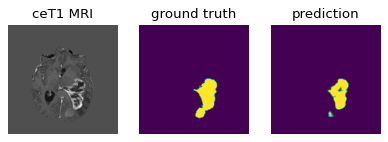

current epoch: 76 current mean dice: 0.8212
best mean dice: 0.8388 at epoch: 64
----------
epoch 77/150
epoch 77 average loss: 0.0962
----------
epoch 78/150
epoch 78 average loss: 0.0946
----------
epoch 79/150
epoch 79 average loss: 0.0918
----------
epoch 80/150
epoch 80 average loss: 0.0935
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA04_343_1/t1ce.nii.gz']


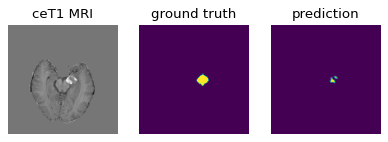

current epoch: 80 current mean dice: 0.8281
best mean dice: 0.8388 at epoch: 64
----------
epoch 81/150
epoch 81 average loss: 0.0877
----------
epoch 82/150
epoch 82 average loss: 0.1115
----------
epoch 83/150
epoch 83 average loss: 0.0941
----------
epoch 84/150
epoch 84 average loss: 0.1025
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA03_474_1/t1ce.nii.gz']


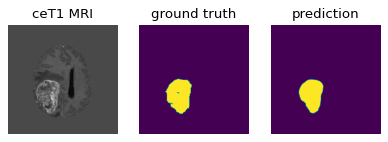

current epoch: 84 current mean dice: 0.8380
best mean dice: 0.8388 at epoch: 64
----------
epoch 85/150
epoch 85 average loss: 0.1021
----------
epoch 86/150
epoch 86 average loss: 0.0946
----------
epoch 87/150
epoch 87 average loss: 0.0876
----------
epoch 88/150
epoch 88 average loss: 0.0838
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA08_162_1/t1ce.nii.gz']


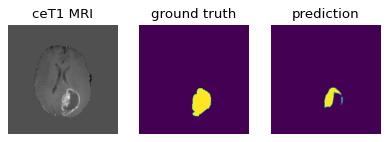

current epoch: 88 current mean dice: 0.8173
best mean dice: 0.8388 at epoch: 64
----------
epoch 89/150
epoch 89 average loss: 0.0874
----------
epoch 90/150
epoch 90 average loss: 0.0853
----------
epoch 91/150
epoch 91 average loss: 0.0877
----------
epoch 92/150
epoch 92 average loss: 0.0781
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA05_277_1/t1ce.nii.gz']


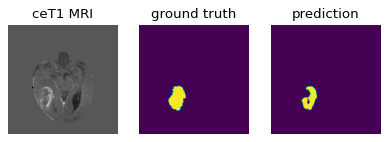

current epoch: 92 current mean dice: 0.8360
best mean dice: 0.8388 at epoch: 64
----------
epoch 93/150
epoch 93 average loss: 0.0867
----------
epoch 94/150
epoch 94 average loss: 0.0927
----------
epoch 95/150
epoch 95 average loss: 0.0902
----------
epoch 96/150
epoch 96 average loss: 0.0929
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA04_437_1/t1ce.nii.gz']


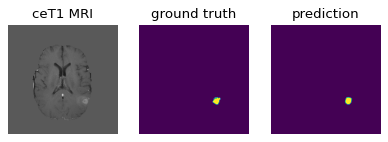

saved new best metric model
current epoch: 96 current mean dice: 0.8460
best mean dice: 0.8460 at epoch: 96
----------
epoch 97/150
epoch 97 average loss: 0.0874
----------
epoch 98/150
epoch 98 average loss: 0.0849
----------
epoch 99/150
epoch 99 average loss: 0.0848
----------
epoch 100/150
epoch 100 average loss: 0.0867
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA04_192_1/t1ce.nii.gz']


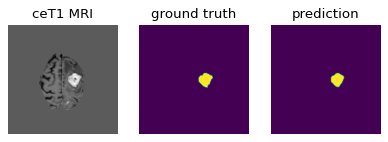

current epoch: 100 current mean dice: 0.7965
best mean dice: 0.8460 at epoch: 96
----------
epoch 101/150
epoch 101 average loss: 0.0877
----------
epoch 102/150
epoch 102 average loss: 0.0784
----------
epoch 103/150
epoch 103 average loss: 0.0895
----------
epoch 104/150
epoch 104 average loss: 0.0945
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA03_375_1/t1ce.nii.gz']


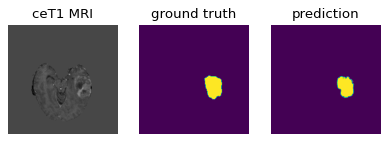

saved new best metric model
current epoch: 104 current mean dice: 0.8675
best mean dice: 0.8675 at epoch: 104
----------
epoch 105/150
epoch 105 average loss: 0.0783
----------
epoch 106/150
epoch 106 average loss: 0.0738
----------
epoch 107/150
epoch 107 average loss: 0.0775
----------
epoch 108/150
epoch 108 average loss: 0.0738
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA03_296_1/t1ce.nii.gz']


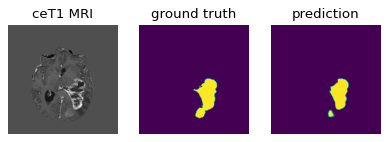

current epoch: 108 current mean dice: 0.8585
best mean dice: 0.8675 at epoch: 104
----------
epoch 109/150
epoch 109 average loss: 0.0781
----------
epoch 110/150
epoch 110 average loss: 0.0715
----------
epoch 111/150
epoch 111 average loss: 0.0774
----------
epoch 112/150
epoch 112 average loss: 0.0772
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA08_205_1/t1ce.nii.gz']


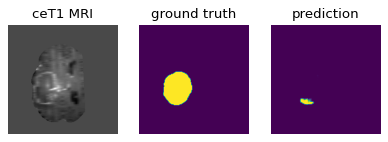

current epoch: 112 current mean dice: 0.8393
best mean dice: 0.8675 at epoch: 104
----------
epoch 113/150
epoch 113 average loss: 0.0802
----------
epoch 114/150
epoch 114 average loss: 0.0759
----------
epoch 115/150
epoch 115 average loss: 0.0861
----------
epoch 116/150
epoch 116 average loss: 0.0788
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA04_111_1/t1ce.nii.gz']


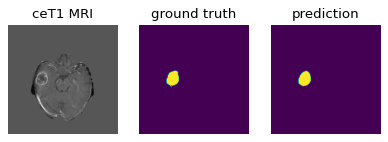

current epoch: 116 current mean dice: 0.8369
best mean dice: 0.8675 at epoch: 104
----------
epoch 117/150
epoch 117 average loss: 0.0780
----------
epoch 118/150
epoch 118 average loss: 0.0753
----------
epoch 119/150
epoch 119 average loss: 0.0708
----------
epoch 120/150
epoch 120 average loss: 0.0731
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA08_278_1/t1ce.nii.gz']


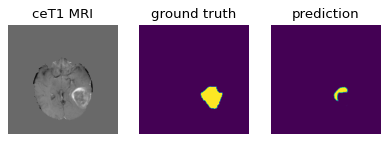

current epoch: 120 current mean dice: 0.8461
best mean dice: 0.8675 at epoch: 104
----------
epoch 121/150
epoch 121 average loss: 0.0702
----------
epoch 122/150
epoch 122 average loss: 0.0870
----------
epoch 123/150
epoch 123 average loss: 0.0795
----------
epoch 124/150
epoch 124 average loss: 0.0724
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA08_105_1/t1ce.nii.gz']


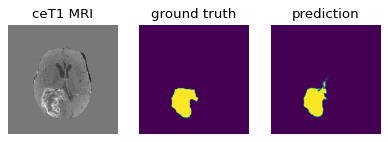

current epoch: 124 current mean dice: 0.8579
best mean dice: 0.8675 at epoch: 104
----------
epoch 125/150
epoch 125 average loss: 0.0662
----------
epoch 126/150
epoch 126 average loss: 0.0836
----------
epoch 127/150
epoch 127 average loss: 0.0743
----------
epoch 128/150
epoch 128 average loss: 0.0795
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA04_192_1/t1ce.nii.gz']


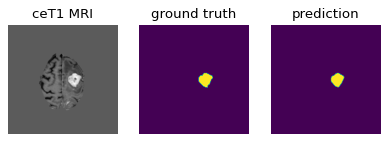

current epoch: 128 current mean dice: 0.8575
best mean dice: 0.8675 at epoch: 104
----------
epoch 129/150
epoch 129 average loss: 0.0714
----------
epoch 130/150
epoch 130 average loss: 0.0724
----------
epoch 131/150
epoch 131 average loss: 0.0768
----------
epoch 132/150
epoch 132 average loss: 0.0666
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA04_343_1/t1ce.nii.gz']


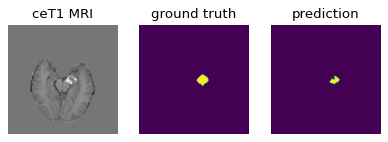

current epoch: 132 current mean dice: 0.8540
best mean dice: 0.8675 at epoch: 104
----------
epoch 133/150
epoch 133 average loss: 0.0777
----------
epoch 134/150
epoch 134 average loss: 0.0779
----------
epoch 135/150
epoch 135 average loss: 0.0733
----------
epoch 136/150
epoch 136 average loss: 0.0655
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA05_277_1/t1ce.nii.gz']


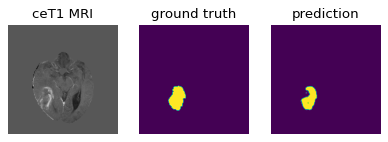

current epoch: 136 current mean dice: 0.8557
best mean dice: 0.8675 at epoch: 104
----------
epoch 137/150
epoch 137 average loss: 0.0761
----------
epoch 138/150
epoch 138 average loss: 0.0692
----------
epoch 139/150
epoch 139 average loss: 0.0703
----------
epoch 140/150
epoch 140 average loss: 0.0776
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA08_278_1/t1ce.nii.gz']


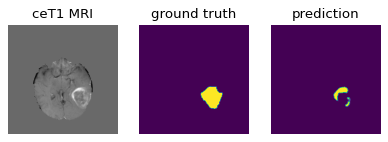

saved new best metric model
current epoch: 140 current mean dice: 0.8785
best mean dice: 0.8785 at epoch: 140
----------
epoch 141/150
epoch 141 average loss: 0.0684
----------
epoch 142/150
epoch 142 average loss: 0.0746
----------
epoch 143/150
epoch 143 average loss: 0.0695
----------
epoch 144/150
epoch 144 average loss: 0.0687
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA03_296_1/t1ce.nii.gz']


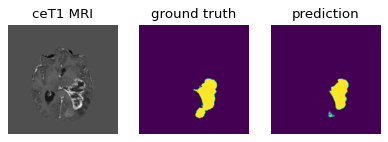

current epoch: 144 current mean dice: 0.8598
best mean dice: 0.8785 at epoch: 140
----------
epoch 145/150
epoch 145 average loss: 0.0788
----------
epoch 146/150
epoch 146 average loss: 0.0781
----------
epoch 147/150
epoch 147 average loss: 0.0763
----------
epoch 148/150
epoch 148 average loss: 0.0706
['/content/drive/MyDrive/Colab Notebooks/data/brats18_train/brats18_train/Brats18_TCIA08_319_1/t1ce.nii.gz']


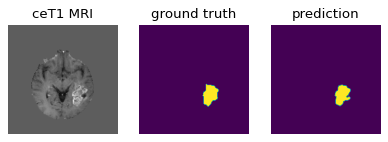

current epoch: 148 current mean dice: 0.8460
best mean dice: 0.8785 at epoch: 140
----------
epoch 149/150
epoch 149 average loss: 0.0701
----------
epoch 150/150
epoch 150 average loss: 0.0729


In [ ]:
root_dir = path0 # model will be saved in this folder

lr = 1e-4
max_epochs = 150
val_interval = 4
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

optimizer = torch.optim.Adam(model.parameters(), lr)

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"],
        )

        labels = (labels==1).type(torch.FloatTensor) + (labels==4).type(torch.FloatTensor)
        labels[labels>0] = 1
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
 
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            disp_val_no = np.random.randint(len(valid_files))
            for val_data in valid_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"],
                )        

                val_labels = (val_labels==1).type(torch.FloatTensor) + (val_labels==4).type(torch.FloatTensor)
                val_labels[val_labels>0] = 1
                val_labels = val_labels.to(device)
                
                roi_size = (160, 160, 64)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model, overlap=0.75)
                val_loss = loss_function(val_outputs, val_labels)
                
                metric_count += 1
                metric_sum += (1-val_loss.sum().item())
                
                if metric_count == disp_val_no:
                  print(val_data['image_meta_dict']['filename_or_obj'])
                  zz = np.argmax(np.sum(np.sum(np.array(val_labels[0,0,:,:,:].cpu()),axis=1),axis=0))
                  val_preds = val_outputs.softmax(1)
                  plt.figure(dpi=dpiv)
                  plt.subplot(131)
                  plt.imshow(np.transpose(val_inputs[0,0,:,:,zz].cpu().numpy(),(1,0)),cmap='gray')
                  plt.axis('off')
                  plt.title('ceT1 MRI')
                  plt.subplot(132)
                  plt.imshow(np.transpose(val_labels[0,0,:,:,zz].cpu().numpy(),(1,0)))
                  plt.axis('off')
                  plt.title('ground truth')
                  plt.subplot(133)
                  plt.imshow(np.transpose(val_preds[0,1,:,:,zz].cpu().numpy(),(1,0)))
                  plt.axis('off')
                  plt.title('prediction')
                  plt.show()
                
            metric = metric_sum / metric_count
            metric_values.append(metric)
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, f"best_metric_model_epoch_{best_metric_epoch}.pth"))    
                print("saved new best metric model")
            
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}")

## plot the loss and metric

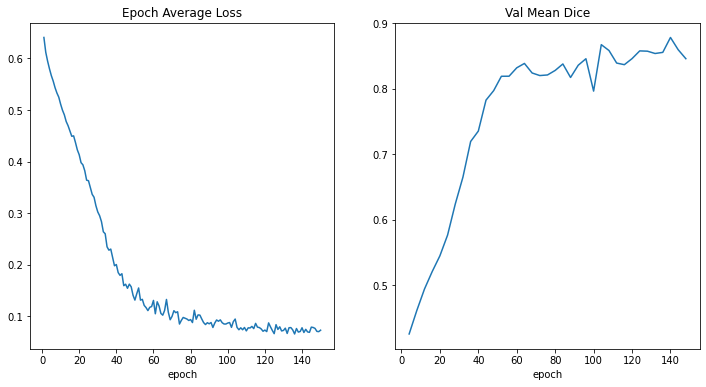

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()